### Setup MLRun Project

In [1]:
import mlrun
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
project = mlrun.get_or_create_project("model-serving-parallel", "./")

> 2023-03-15 16:32:57,956 [info] loaded project parallel-inferencing-share from MLRun DB


![](img/parallel_inferencing_diagram.png)

### Define Model Class, Router, and Transformations

In [4]:
%%writefile parallel_inferencing_share.py
from typing import List

import numpy as np
import storey
from cloudpickle import load

import mlrun
from mlrun.serving.routers import ParallelRun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()
    
    def postprocess(self, request):
        print("Pred:", request)
        return request
    
def postprocess(event):
    print()
    print(f"Post-processing in: {event}")
    event = {"inputs" : list(zip(*event.values()))}
    print(f"Post-processing out: {event}")
    print()
    return event

class ParallelRouter(ParallelRun):
        
    def merger(self, body, results):
        """Merging logic
        input the event body and a dict of route results and returns a dict with merged results
        
        Incoming results dictionary will look like:
        results = {
            'sepal_length_cm': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'sepal_length_cm', 'outputs': [0, 2]},
            'petal_width_cm': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'petal_width_cm', 'outputs': [0, 2]},
            'petal_length_cm': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'petal_length_cm', 'outputs': [0, 2]},
            'sepal_width_cm': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'sepal_width_cm', 'outputs': [0, 2]}
        }
        
        Merged result will look like:
        merged = {
            'sepal_length_cm': [0, 2],
            'petal_width_cm': [0, 2],
            'petal_length_cm': [0, 2],
            'sepal_width_cm': [0, 2]
        }
        """
        print()
        print("Merger in:", results)
        merged = {result["model_name"] : result["outputs"] for result in results.values()}
        print("Merger out:", merged)
        return merged

Overwriting parallel_inferencing_share.py


### Define Graph

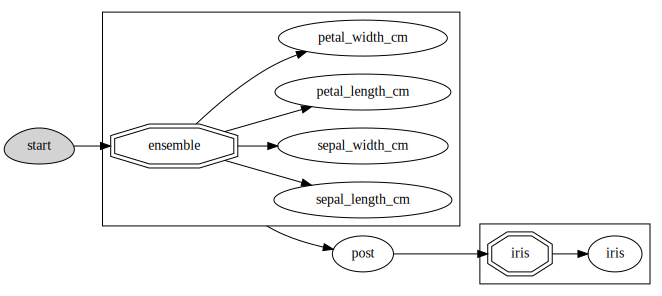

In [5]:
fn = project.set_function(
    name="advanced", func="parallel_inferencing_share.py", 
    kind="serving", image="mlrun/mlrun"
)
graph = fn.set_topology("flow", engine="async")

router = graph.add_step("*ParallelRouter", name="ensemble")
router.add_route("sepal_length_cm", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")
router.add_route("sepal_width_cm", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")
router.add_route("petal_length_cm", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")
router.add_route("petal_width_cm", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

graph.add_step(name="post", handler="postprocess", after="$prev")

router2 = graph.add_step("*mlrun.serving.ModelRouter", name="iris", after="$prev").respond()
router2.add_route("iris", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

graph.plot(rankdir="LR")

### Test Locally

In [6]:
mock_server = fn.to_mock_server()

> 2023-03-15 16:33:13,348 [info] model sepal_length_cm was loaded
> 2023-03-15 16:33:13,470 [info] model sepal_width_cm was loaded
> 2023-03-15 16:33:13,613 [info] model petal_length_cm was loaded
> 2023-03-15 16:33:13,747 [info] model petal_width_cm was loaded
> 2023-03-15 16:33:13,748 [info] Loaded ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']
> 2023-03-15 16:33:13,943 [info] model iris was loaded
> 2023-03-15 16:33:13,944 [info] Loaded ['iris']


In [7]:
body = {
    "inputs" : [
        [5.4, 3.9, 1.3, 0.4],
        [6.9, 3.1, 5.1, 2.3],
        [6.7, 2.5, 5.8, 1.8],
        [5.5, 2.3, 4.0, 1.3],
        [4.6, 3.4, 1.4, 0.3]
    ]
}

In [15]:
mock_server.test("", body=body)

Pred: {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'petal_length_cm', 'outputs': [0, 2, 2, 1, 0]}
Pred: {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'sepal_length_cm', 'outputs': [0, 2, 2, 1, 0]}
Pred: {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'petal_width_cm', 'outputs': [0, 2, 2, 1, 0]}
Pred: {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'sepal_width_cm', 'outputs': [0, 2, 2, 1, 0]}

Merger in: {'petal_length_cm': {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'petal_length_cm', 'outputs': [0, 2, 2, 1, 0]}, 'sepal_length_cm': {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'sepal_length_cm', 'outputs': [0, 2, 2, 1, 0]}, 'petal_width_cm': {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'petal_width_cm', 'outputs': [0, 2, 2, 1, 0]}, 'sepal_width_cm': {'id': 'f9d6b7ba6a9140b8952d5dc0956103b3', 'model_name': 'sepal_width_cm', 'outputs': [0, 2, 2, 1, 0]}}
Merger out: {'petal_length_cm': [0, 2, 2, 1, 0], 'sepal_l

{'id': 'f9d6b7ba6a9140b8952d5dc0956103b3',
 'model_name': 'iris',
 'outputs': [0, 1, 1, 1, 0]}

### Deploy on K8s

In [15]:
fn.deploy()

> 2023-03-07 20:47:43,951 [info] Starting remote function deploy
2023-03-07 20:47:45  (info) Deploying function
2023-03-07 20:47:45  (info) Building
2023-03-07 20:47:45  (info) Staging files and preparing base images
2023-03-07 20:47:45  (info) Building processor image
2023-03-07 20:48:40  (info) Build complete
2023-03-07 20:48:48  (info) Function deploy complete
> 2023-03-07 20:48:49,669 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-parallel-inferencing-share-advanced.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['parallel-inferencing-share-advanced-parallel-inferencing-share.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


'http://parallel-inferencing-share-advanced-parallel-inferencing-share.default-tenant.app.us-sales-350.iguazio-cd1.com/'

In [16]:
fn.invoke("", body=body)

> 2023-03-07 21:02:40,975 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-parallel-inferencing-share-advanced.default-tenant.svc.cluster.local:8080/'}


{'id': 'b739a3eb-3ae4-47aa-90e7-4a676746fd01',
 'model_name': 'iris',
 'outputs': [0, 1, 1, 1, 0]}